In [13]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from modules import VBZ

In [14]:
#Path to the data. Change on your own computer
#G Computer:
#data_path = '/home/gp/Datasets/VBZ/'
#C Computer:
data_path = 'C:\\Data\\'

# Data load and initial cleanup

>We load the data for the arrival and departure times as well as the data for the tram/busstops.
>We also add some additional columns for further readability and to make future tasks easier

In [15]:
#Loading the data for arrival and departure times, including target and actual times.
path_to_fahrzeiten = data_path + "fahrzeiten_soll_ist_20180715_20180721.csv"
fahrzeiten_data = pd.read_csv(path_to_fahrzeiten);
print(fahrzeiten_data.columns.values)
fahrzeiten_data.head()

['linie' 'richtung' 'betriebsdatum' 'fahrzeug' 'kurs' 'seq_von'
 'halt_diva_von' 'halt_punkt_diva_von' 'halt_kurz_von1' 'datum_von'
 'soll_an_von' 'ist_an_von' 'soll_ab_von' 'ist_ab_von' 'seq_nach'
 'halt_diva_nach' 'halt_punkt_diva_nach' 'halt_kurz_nach1' 'datum_nach'
 'soll_an_nach' 'ist_an_nach1' 'soll_ab_nach' 'ist_ab_nach' 'fahrt_id'
 'fahrweg_id' 'fw_no' 'fw_typ' 'fw_kurz' 'fw_lang' 'umlauf_von'
 'halt_id_von' 'halt_id_nach' 'halt_punkt_id_von' 'halt_punkt_id_nach']


,linie,richtung,betriebsdatum,fahrzeug,kurs,seq_von,halt_diva_von,halt_punkt_diva_von,halt_kurz_von1,datum_von,...,fahrweg_id,fw_no,fw_typ,fw_kurz,fw_lang,umlauf_von,halt_id_von,halt_id_nach,halt_punkt_id_von,halt_punkt_id_nach
0,2,1,15.07.18,2083,6,1,6030,0,DEP4,15.07.18,...,79519,15,2,15,DEP4 - KALK,162622,2251,1906,32451,10563
1,2,1,15.07.18,3034,3,1,478,0,BEZI,15.07.18,...,79515,11,1,11,BEZI - BTIE für Ausfahrt,160677,1306,1502,32822,32369
2,2,1,15.07.18,3034,3,5,601,0,BOES,15.07.18,...,79515,11,1,11,BEZI - BTIE für Ausfahrt,160677,2228,2590,32880,33358
3,2,1,15.07.18,3034,3,4,1861,0,PARA,15.07.18,...,79515,11,1,11,BEZI - BTIE für Ausfahrt,160677,1528,2228,32123,32880
4,2,1,15.07.18,3034,3,3,2396,0,SIHS,15.07.18,...,79515,11,1,11,BEZI - BTIE für Ausfahrt,160677,2657,1528,10574,32123


In [16]:
#Loading the data for the tram/busstops in order to map internal codes to actual stopnames.
path_to_haltestellen = data_path + 'haltestelle.csv';
haltestellen_data = pd.read_csv(path_to_haltestellen);
haltestellen_data.head()

,halt_id,halt_diva,halt_kurz,halt_lang,halt_ist_aktiv
0,143,2570,BirmSte,"Birmensdorf ZH, Sternen/WSL",True
1,309,3356,WaldBir,"Waldegg, Birmensdorferstrasse",True
2,373,6232,FRAF07,"Zürich Flughafen, Fracht",True
3,539,2655,TBAH01,"Thalwil, Bahnhof",True
4,588,3027,FLUG07,"Zürich Flughafen, Bahnhof",True


>We make the arrival and departure times more human readable and put them into datetime objects that we can manipulate later

In [17]:
#Using the date of the connection as well as the seconds since midnight to put arrival and departure times (target and actual) into machine readable format
fahrzeiten_data['ankunft_soll'] = pd.Series([VBZ.datetime_from_date_and_seconds(d,s) 
                                             for (d,s) in zip(fahrzeiten_data['betriebsdatum'].tolist(),fahrzeiten_data['soll_an_von'].tolist())]);
fahrzeiten_data['ankunft_ist'] = pd.Series([VBZ.datetime_from_date_and_seconds(d,s) 
                                            for (d,s) in zip(fahrzeiten_data['betriebsdatum'].tolist(),fahrzeiten_data['ist_an_von'].tolist())])
fahrzeiten_data['abfahrt_soll'] = pd.Series([VBZ.datetime_from_date_and_seconds(d,s) 
                                             for (d,s) in zip(fahrzeiten_data['betriebsdatum'].tolist(),fahrzeiten_data['soll_ab_von'].tolist())]);
fahrzeiten_data['ankunft_ist'] = pd.Series([VBZ.datetime_from_date_and_seconds(d,s) 
                                            for (d,s) in zip(fahrzeiten_data['betriebsdatum'].tolist(),fahrzeiten_data['ist_ab_von'].tolist())])

# Analyzing deviations between target and actual arrival times

>We compute and analyze deviations between target and actual arrival times, looking specifically for delays

In [18]:
#Threshold: We exclude arrivals that are more than 5 minutes early or more than 30 minutes late
threshold_lower = -300;
threshold_upper = 1800;

In [19]:
#Computing the deviation in arrival times, both in datetime and in seconds
fahrzeiten_data['deviation_datetime'] = fahrzeiten_data['ankunft_ist'] - fahrzeiten_data['ankunft_soll'];
fahrzeiten_data['deviation_in_sec'] = fahrzeiten_data.deviation_datetime.apply(lambda d:d.total_seconds());
fahrzeiten_data[['linie','ankunft_ist','ankunft_soll','deviation_datetime','deviation_in_sec']].head()

,linie,ankunft_ist,ankunft_soll,deviation_datetime,deviation_in_sec
0,2,2018-07-15 04:53:31,2018-07-15 04:53:00,00:00:31,31.0
1,2,2018-07-15 04:56:55,2018-07-15 04:56:42,00:00:13,13.0
2,2,2018-07-15 05:03:48,2018-07-15 05:03:42,00:00:06,6.0
3,2,2018-07-15 05:02:35,2018-07-15 05:02:36,-1 days +23:59:59,-1.0
4,2,2018-07-15 05:00:39,2018-07-15 05:00:54,-1 days +23:59:45,-15.0


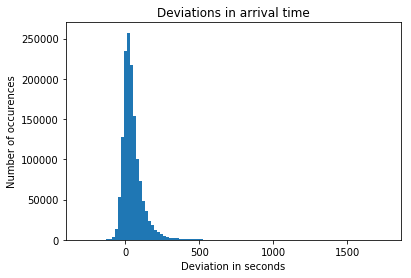

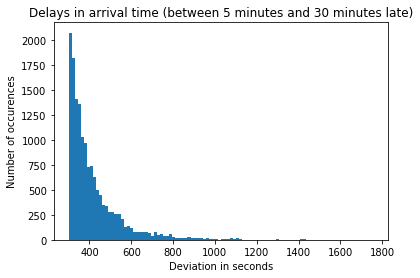

In [20]:
#Plotting the deviation histograms, filtering out any connectionthat arrived 10 minutes or more
#early (assumed mistake/outlier) or more than 1h late (assumed failure)
s = fahrzeiten_data['deviation_in_sec'];
plt.hist(s[s>threshold_lower][s<threshold_upper],100);
plt.title('Deviations in arrival time');
plt.ylabel('Number of occurences');
plt.xlabel('Deviation in seconds');
plt.show();
plt.hist(s[s>300][s<1800],100);
plt.title('Delays in arrival time (between 5 minutes and 30 minutes late)')
plt.ylabel('Number of occurences')
plt.xlabel('Deviation in seconds')
plt.show()

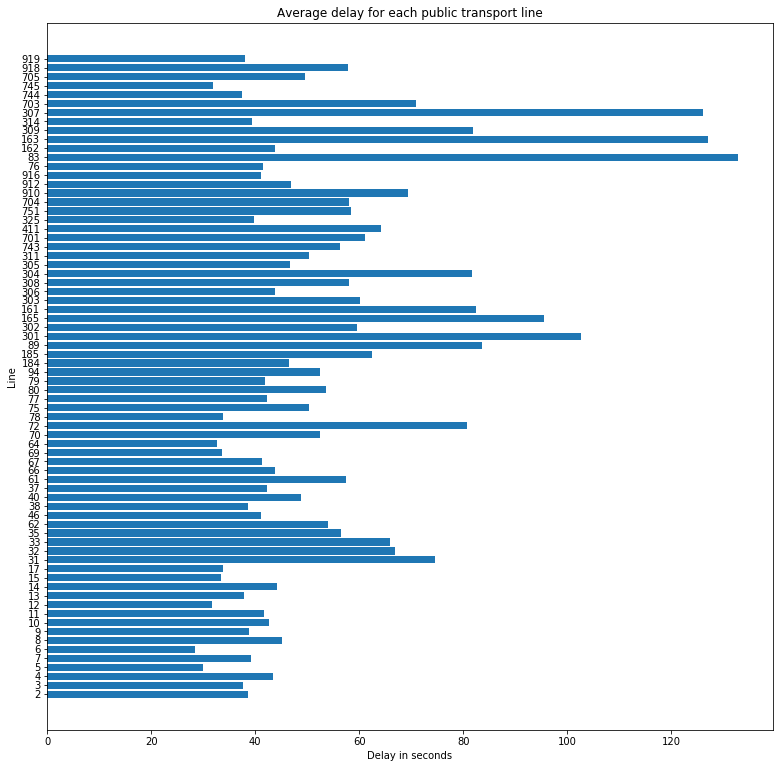

In [24]:
#Plotting the average delay for each line. If the line arrives early, the deviation is set to 0. 
#Outliers (more than 1h late) are excluded
lines = fahrzeiten_data.linie.unique();
average_delay = {};
for line in lines:
    average_delay[line] = (fahrzeiten_data['deviation_in_sec']
                           [fahrzeiten_data['deviation_in_sec']>threshold_lower]
                           [fahrzeiten_data['deviation_in_sec']<threshold_upper]
                           [fahrzeiten_data['linie']==line]
                           .clip(lower=0)
                           .mean())
plt.figure(figsize=(13,13))
plt.barh(range(len(average_delay)),list(average_delay.values()))
plt.yticks(range(len(average_delay)),average_delay.keys())
plt.title('Average delay for each public transport line')
plt.ylabel('Line')
plt.xlabel('Delay in seconds')
plt.show()

In [25]:
#Checking the stops for line 14 to confirm that internal and external line numbers are the same
h_ids_14 = fahrzeiten_data['halt_id_von'][fahrzeiten_data['linie']==14];
haltestellen_data['halt_lang'][haltestellen_data['halt_id'].isin(h_ids_14)]

6            Zürich, Goldbrunnenplatz
16      Zürich, Schaufelbergerstrasse
20                    Zürich, Triemli
27           Zürich, Sternen Oerlikon
55                Zürich, Stauffacher
57                  Zürich, Milchbuck
73        Zürich, Hirschwiesenstrasse
75                       Zürich, Werd
80          Zürich, Schaffhauserplatz
82            Zürich, Bahnhofplatz/HB
83             Zürich, Bahnhofquai/HB
87           Zürich, Bahnhof Wiedikon
93                    Zürich, Seebach
118          Zürich, Bahnhof Oerlikon
127         Zürich, Felsenrainstrasse
139                   Zürich, Heuried
143      Zürich, Bahnhof Oerlikon Ost
181            Zürich, Guggachstrasse
193         Zürich, Schmiede Wiedikon
203                 Zürich, Beckenhof
204             Zürich, Kronenstrasse
205         Zürich, Stampfenbachplatz
238    Zürich, Depot 4 Elisabethenstr
241                Zürich, Löwenplatz
245             Zürich, Sihlpost / HB
248              Zürich, Berninaplatz
258         

C:\Users\ChrisBo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


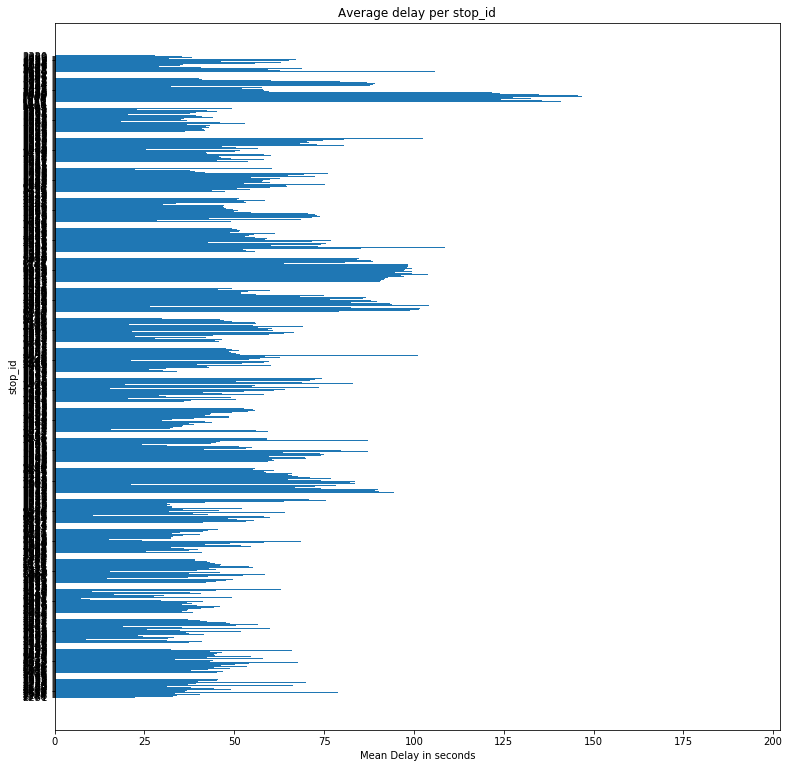

In [29]:
#Plotting the average delay for each line. If the line arrives early, the deviation is set to 0. 
#Outliers (more than 1h late) are excluded
stops = fahrzeiten_data.halt_id_von.unique();
average_delay_stops = {};
fahrzeit_tmp=(fahrzeiten_data[fahrzeiten_data['deviation_in_sec']>threshold_lower]
                           [fahrzeiten_data['deviation_in_sec']<threshold_upper])
for stop in stops:
    average_delay_stops[stop] = (fahrzeit_tmp['deviation_in_sec']
                           [fahrzeit_tmp['halt_id_von']==stop]
                           .clip(lower=0)
                           .mean())


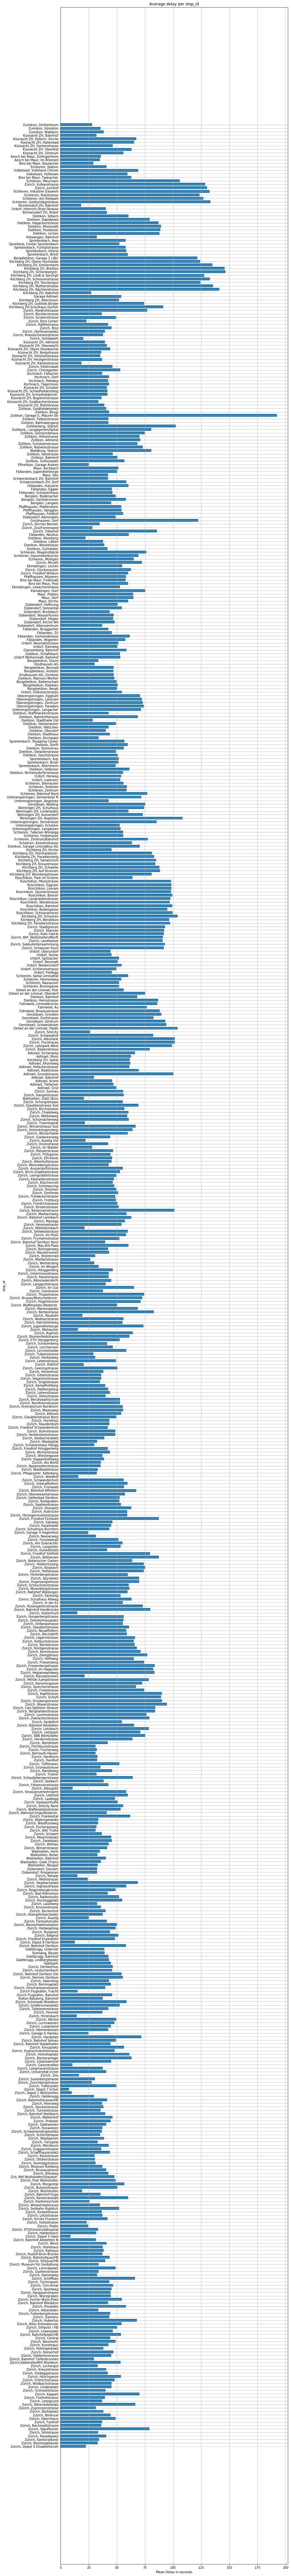

In [37]:
                           
plt.figure(figsize=(13,150))
plt.barh(range(len(average_delay_stops)),list(average_delay_stops.values()))
plt.yticks(range(len(average_delay_stops)),[haltestellen_data['halt_lang'][haltestellen_data['halt_id']==stop].iloc[0] for stop in  average_delay_stops.keys() ])
plt.title('Average delay per stop_id')
plt.ylabel('stop_id')
plt.xlabel('Mean Delay in seconds')
plt.grid(b=True)
plt.show()

In [59]:
average_delay_stops[2011]


192.2888888888889

In [58]:
haltestellen_data[haltestellen_data['halt_lang']=='Zollikon, Garage G.-Maurer-Str']

,halt_id,halt_diva,halt_kurz,halt_lang,halt_ist_aktiv
155,2011,6044,GAAZ,"Zollikon, Garage G.-Maurer-Str",True
